$\textbf{Importing all necessary modules}$: importing modules for setting up machine learning model, visualization of results, and making organized dataset out of given raw data. Also, setting the seed to make it reproducible

In [161]:
from pysr import PySRRegressor
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import os
import glob
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import joblib
from pathlib import Path
np.random.seed(2023)
torch.manual_seed(2023)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Typesetting our plots (specifiying a format for visualization)

In [4]:
def prettify(ax, spine_width=1.4):
    # white background
    ax.set_facecolor("white")

    # bounding box
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color("black")
        spine.set_linewidth(spine_width)

    # tick styling
    ax.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        bottom=True,
        left=True,
        right=True,
        length=6,
        width=1.1
    )
    ax.minorticks_on()
# Global style for all figures
plt.rcParams.update({
    "figure.dpi": 150,         # on-screen
    "savefig.dpi": 600,        # file export
    "font.size": 9,
    "lines.linewidth": 1.6,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 9,
    })
legend_kw = dict(
    frameon=True,
    handlelength=2.0,
    handletextpad=0.8,
    labelspacing=0.6,
    borderpad=0.8
)

# Preprocessing step 1 (Making a .csv file from the given raw simulation file):

In [ ]:
import os
import glob
import pandas as pd
import numpy as np

phi_values = [30, 35, 40, 45, 50]  # Given phi values
big_dfs = []  # Will hold final DataFrames

for phi in phi_values:
    folder_phi = f"phi_{phi}"

    # Dynamically find available Pe values for this phi
    pe_folders = glob.glob(os.path.join(folder_phi, "theta_aniso_pe_*"))
    pe_values = sorted([int(folder.split("_")[-1]) for folder in pe_folders if folder.split("_")[-1].isdigit()])
    
    print(f"Found Pe values for phi={phi}: {pe_values}")

    for pe in pe_values:
        folder_pe = os.path.join(folder_phi, f"theta_aniso_pe_{pe}")
        
        # Find relevant .txt files
        file_paths = glob.glob(os.path.join(folder_pe, "rdftheta90_frame_-*.txt"))
        if not file_paths:
            print(f"No files found for phi={phi}, Pe={pe}")
            continue
        
        # Collect data from multiple files
        df_list = []
        for file_path in file_paths:
            temp_df = pd.read_csv(file_path, skiprows=1, sep='\s+', header=None)
            df_list.append(temp_df)

        # Combine all files for this phi-Pe
        combined_df = pd.concat(df_list, axis=0, ignore_index=True)

        # Ensure the number of columns is correct
        column_names = ["r"] + [f"g[{i}]" for i in range(90)]
        if len(combined_df.columns) != 91:  # 1 'r' + 90 'g' columns
            print(f"Unexpected number of columns in {file_path}: {len(combined_df.columns)}")
            continue

        combined_df.columns = column_names

        # Compute the theta-average directly (mean over all 90 g columns)
        combined_df["g_avg"] = combined_df[[f"g[{i}]" for i in range(90)]].mean(axis=1)

        # Keep only r and g_avg
        avg_df = combined_df[["r", "g_avg"]].copy()

        # Add phi and Pe columns
        avg_df.insert(0, "phi", phi)
        avg_df.insert(1, "Pe", pe)

        # Reorder columns
        avg_df = avg_df[["phi", "Pe", "r", "g_avg"]]

        big_dfs.append(avg_df)

# Combine all phi/Pe data
final_df_avg = pd.concat(big_dfs, ignore_index=True)

print("Final averaged DataFrame shape:", final_df_avg.shape)
final_df_avg.to_csv("all_phi_pe_r_g_avg.csv", index=False)


# $\text{Preprocessing step 2}$ 
$\text{(Scaling the transformed simulation datafiles to make it suitable to be used for Deep learning)}$

Note: scaler_pe.joblib is given separately (this is just the min_max scale that has been applied across all the cases on Peclet numbers)

In [20]:
#final_df = pd.read_csv('concatenated_file.csv')
import joblib
scaler_pe = joblib.load("scaler_pe.joblib")
avg_theta_df = pd.read_csv("all_phi_pe_r_g_avg.csv")
avg_theta_df["phi"] = avg_theta_df["phi"] / 100.0
avg_theta_df["scaled_Pe"] = scaler_pe.fit_transform(avg_theta_df[["Pe"]])   #scale it back: scaler_pe.inverse_transform(scaled_Pe_pred)

avg_theta_df

,phi,Pe,r,g_avg,scaled_Pe
0,0.3,15,0.0125,0.000000,0.333333
1,0.3,15,0.0375,0.000000,0.333333
2,0.3,15,0.0625,0.000000,0.333333
3,0.3,15,0.0875,0.000000,0.333333
4,0.3,15,0.1125,0.000000,0.333333
...,...,...,...,...,...
83995,0.5,35,4.8875,1.018722,0.777778
83996,0.5,35,4.9125,1.029415,0.777778
83997,0.5,35,4.9375,1.032912,0.777778
83998,0.5,35,4.9625,1.052695,0.777778


In [51]:
X = avg_theta_df[["phi", "scaled_Pe", "r"]].to_numpy()
y = avg_theta_df["g_avg"].to_numpy().reshape(-1,1)
y = np.log1p(y)             # later, to invert it: y_pred = np.expm1(y_pred_scaled).reshape(-1)
n_data_scaled = np.hstack([X, y])
n_data_scaled.shape

(84000, 4)

# $\text{Preprocessing step 3 - final}$
($\text{Preparing training and testing dataset}$)

In [52]:
class correlationDataset(Dataset):
    def __init__(self, data):
        self.g_r = data
        
    def __len__(self):
        return self.g_r.shape[0]
        
    def __getitem__(self, idx):
        inputs = self.g_r[idx,:-1]
        g = self.g_r[idx,-1]    
        return torch.FloatTensor(inputs), torch.FloatTensor([g])

In [ ]:
from sklearn.model_selection import train_test_split

#Creation of dataset and dataloader
tr_set, te_set = train_test_split(n_data_scaled, test_size=0.15, random_state=42)
tr_set = correlationDataset(tr_set)
te_set = correlationDataset(te_set)
batch_size = 256
trainloader = DataLoader(tr_set, batch_size=batch_size, shuffle=True)
testloader= DataLoader(te_set, batch_size=batch_size, shuffle=True)

# $\text{Model design and training pipeline}$ (Step 2)
Our model architecture consists of a basic Multi-layer perceptron (MLP), also referred to as a Fully Connected Neural Network (FCNN). The model will take in a tensor of values, namely $[r, Pe, \varphi]$, as input and produce a tensor $[\mathrm{g}(r)]$ as output. The number of hidden layers can also be adjusted using the input list ```hidden_dims = [layer_1, layer_2, ..., layer_n]``` depending on the complexity of the system. We use PyTorch throughout this notebook that provides 'the elegantly designed modules and classes', such as: torch.nn, torch.optim, Dataset, and DataLoader. 

In [21]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims): 
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dims[i-1], hidden_dims[i]) for i in range(1, len(hidden_dims))
        ])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x):
        x = nn.functional.relu(self.input_layer(x)) 
        for layer in self.hidden_layers:
            x = nn.functional.leaky_relu(layer(x)) 
        x = self.output_layer(x)
  
        return x

# Designing the model training function

In [54]:
from sklearn.metrics import r2_score
def train_model(model, trainloader, testloader, loss_fn, optimizer, num_epochs):
    train_losses, test_losses = [], []
    train_r2s, test_r2s = [], []

    best_test_loss = float('inf')
    patience, patience_counter = 20, 0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        y_train_true, y_train_pred = [], []

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device).float(), targets.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets) 
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            y_train_true.append(targets.detach().cpu().numpy())
            y_train_pred.append(outputs.detach().cpu().numpy())

        avg_train_loss = running_train_loss / len(trainloader)
        y_train_true = np.concatenate(y_train_true)
        y_train_pred = np.concatenate(y_train_pred)
        avg_train_r2 = r2_score(y_train_true, y_train_pred)

        # ---- evaluation ----
        model.eval()
        running_test_loss = 0.0
        y_test_true, y_test_pred = [], []

        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device).float(), targets.to(device).float()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                running_test_loss += loss.item()
                y_test_true.append(targets.detach().cpu().numpy())
                y_test_pred.append(outputs.detach().cpu().numpy())

        avg_test_loss = running_test_loss / len(testloader)
        y_test_true = np.concatenate(y_test_true)
        y_test_pred = np.concatenate(y_test_pred)
        avg_test_r2 = r2_score(y_test_true, y_test_pred)

        # logging
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_r2s.append(avg_train_r2)
        test_r2s.append(avg_test_r2)

        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs} — "
                  f"Train Loss: {avg_train_loss:.4f}, R²: {avg_train_r2:.3f} | "
                  f"Test Loss: {avg_test_loss:.4f}, R²: {avg_test_r2:.3f}")

    return train_losses, test_losses, train_r2s, test_r2s


# Finally: the model is being trained

We split the dataset in training(85%) and testing(15%) sub-datasets. We set the hyperparameters :batch size, epoch, learning rate etc. here. We use mean squared error (MSE) as our loss function, and weighted ADAM optimizer (ADAMW). The provided values of hyperparameters in the code block are found to be the optimal ones for our case. Finally the training and testing loss is plotted which shows convergence.

In [61]:
input_dim = 3 
output_dim = 1
hidden_dims = [256,256,256]

model = MLP(input_dim, output_dim, hidden_dims).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

# Define the loss function
loss_fn = nn.MSELoss()
# Set the number of epochs to train for
num_epochs = 201
train_losses, test_losses, train_accuracy, test_accuracy = train_model(model, trainloader,
                                        testloader,  loss_fn,
                                        optimizer, num_epochs)


Epoch 1/201 — Train Loss: 0.0516, R²: 0.594 | Test Loss: 0.0290, R²: 0.777
Epoch 11/201 — Train Loss: 0.0025, R²: 0.980 | Test Loss: 0.0034, R²: 0.974
Epoch 21/201 — Train Loss: 0.0019, R²: 0.985 | Test Loss: 0.0016, R²: 0.987
Epoch 31/201 — Train Loss: 0.0032, R²: 0.974 | Test Loss: 0.0016, R²: 0.988
Epoch 41/201 — Train Loss: 0.0011, R²: 0.991 | Test Loss: 0.0011, R²: 0.991
Epoch 51/201 — Train Loss: 0.0010, R²: 0.992 | Test Loss: 0.0010, R²: 0.992
Epoch 61/201 — Train Loss: 0.0009, R²: 0.993 | Test Loss: 0.0009, R²: 0.993
Epoch 71/201 — Train Loss: 0.0008, R²: 0.994 | Test Loss: 0.0007, R²: 0.994
Epoch 81/201 — Train Loss: 0.0007, R²: 0.994 | Test Loss: 0.0007, R²: 0.995
Epoch 91/201 — Train Loss: 0.0025, R²: 0.980 | Test Loss: 0.0013, R²: 0.990
Epoch 101/201 — Train Loss: 0.0006, R²: 0.995 | Test Loss: 0.0007, R²: 0.995
Early stopping at epoch 103


<IPython.core.display.Javascript object>

# Visualization of the loss

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


# Define colorblind-friendly colors
cb_training = '#0072B2'  # Blue for training
cb_testing = '#D55E00'   # Orange for testing
#colors = ["#0072B2", "#E69F00", "#009E73", "#D55E00", "#CC79A7", "#56B4E9"]  ## Blue,Orange,Green,Red,Purple,Sky blue

# Set font properties for a more professional look
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})


fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), dpi=600)  
ax1, ax2 = axs.flatten()

# Plot losses on the first axis
ax1.plot(np.arange(len(train_losses)), train_losses,linestyle='None',marker='o',markersize=4.0, markeredgewidth=0.4,color = cb_training, label="Training Loss")
ax1.plot(np.arange(len(test_losses)), test_losses, label="Testing Loss", color=cb_testing, linewidth=2.5)
#ax1.set_title("Evolution of Model Training and Testing Loss")
ax1.legend()
ax1.set_ylabel("MSE Loss")
ax1.set_xlabel("Epoch")

# Plot accuracies on the second axis
ax2.plot(np.arange(len(train_accuracy)), train_accuracy,linestyle='None',marker='o',markersize=4.0, markeredgewidth=0.4,color = cb_training, label=r"Training $r^2$")
ax2.plot(np.arange(len(test_accuracy)), test_accuracy, label=r"Testing $r^2$", color=cb_testing, linewidth=2.5)
#ax2.set_title("Evolution of Model Training and Testing Accuracy")
ax2.legend()
ax2.set_ylabel(r"$r^2$")
ax2.set_xlabel("Epoch")


# Add grids and clean up spines for a professional appearance
for ax in [ax1, ax2]:
    #ax.grid(True, linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
# Print final losses
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Testing Loss: {test_losses[-1]:.4f}")

# Adjust layout
plt.tight_layout()

out_dir = Path("figures_grtheta")
out_dir.mkdir(parents=True, exist_ok=True)

plt.savefig(out_dir / 'ABPavg_model_performance.png', dpi=300, bbox_inches="tight")
plt.close()
#plt.show()

In [63]:
plt.figure(figsize=(4, 3))
ax = plt.gca()

# --- Clean white background ---
ax.set_facecolor("white")
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.4)   # thickness similar to your example
    spine.set_color("black")

plt.plot(np.arange(len(test_losses)),test_losses, label = "Validation", color="#8b0000",  # dark red
                                                marker='s',                    # square marker
                                                markersize=4.5,
                                                linewidth=1.4,
                                                linestyle='--',
                                                markerfacecolor='none',
                                                alpha=0.85)
plt.plot(np.arange(len(train_losses)),train_losses, label='Train',
        color="#4f6d6a",               # greenish-grey like the example
        marker='o',
        markersize=4.5,
        linewidth=1.6,
        markerfacecolor='white',
        alpha=0.85        
        )

#plt.title(f'Model vs True g(r) for φ = {p}', fontsize=12)
plt.xlabel("Epoch") #, fontsize=12
plt.ylabel("Loss (units)")
plt.legend(frameon=True)
# General style
plt.tick_params(axis='both', which='major', direction='in')
plt.grid(False)
plt.tight_layout()
out_dir = Path("figures_grtheta")
out_dir.mkdir(parents=True, exist_ok=True)

plt.savefig(out_dir / 'loss_pephi.svg', dpi=600, bbox_inches="tight")
plt.close()
#plt.show()

$\text{Saving the training and testing loss arrays (optional)}$

In [127]:
np.save('train_losses_PCF_ABP_pephir.npy', train_losses)   
#d = np.load('train_losses_PCF_ABP_pephir.npy')
np.save('test_losses_PCF_ABP_pephir.npy', test_losses)   

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
out_dir = Path("figures_grtheta")
out_dir.mkdir(parents=True, exist_ok=True)
ax = plt.gca()
train_losses = np.load('train_losses_PCF_ABP_pephir.npy')
test_losses = np.load('test_losses_PCF_ABP_pephir.npy')
# --- Clean white background ---
ax.set_facecolor("white")
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.4)   # thickness similar to your example
    spine.set_color("black")

plt.plot(np.arange(len(test_losses)),test_losses, label = "Validation", color="#8b0000",  # dark red
                                                marker='s',                    # square marker
                                                markersize=4.5,
                                                linewidth=1.5,
                                                linestyle='--',
                                                markerfacecolor='none',
                                                alpha=0.85)
plt.plot(np.arange(len(train_losses)),train_losses, label='Train',
        color="#4f6d6a",               # greenish-grey like the example
        marker='o',
        markersize=4.5,
        linewidth=1.5,
        markerfacecolor='white',
        alpha=0.85        
        )

#plt.title(f'Model vs True g(r) for φ = {p}', fontsize=12)
plt.xlabel("Epoch") #, fontsize=12
plt.ylabel("Loss")
plt.legend(frameon=True)
# General style
plt.tick_params(axis='both', which='major', direction='in')
plt.grid(False)
plt.tight_layout()
stem = f"loss_ABP_symmetric"
plt.savefig(out_dir / f"{stem}.svg", bbox_inches="tight")
#plt.savefig(out_dir / f"{stem}.png", bbox_inches="tight")
#plt.show()
plt.close()

$\text{Saving the model (not optional)}$

In [12]:
torch.save(model.state_dict(), 'model_weights_gr_in_2d.pth')

# We might start from here to work with the trained model
If we just want to test how our pre-trained model is working for known or unknown parameters later, we can start from the code block below (run the model code block first though). We set the eval() mode for the model as we are not training anymore, just testing.

In [22]:
from pathlib import Path
out_dir = Path("figures_grtheta")
out_dir.mkdir(parents=True, exist_ok=True)
input_dim = 3
output_dim = 1
hidden_dims = [256,256,256]
model = MLP(input_dim, output_dim, hidden_dims)  # same architecture
model.load_state_dict(torch.load('model_weights_gr_in_2d.pth'))
model.to(device)
model.eval()

MLP(
  (input_layer): Linear(in_features=3, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [5]:
# All possible saving techniques for the model or even part of it!!
'''
TO LOAD THE SAVED MODEL (EASY WAY)
model = MLP(input_dim, output_dim, hidden_dims)  # same architecture
model.load_state_dict(torch.load('model_weights.pth'))
model.to(device)
model.eval()  # if you're doing inference

TO SAVE THE OPTIMIZER STATE (useful if you plan to resume training):
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': input_dim,
    'output_dim': output_dim,
    'hidden_dims': hidden_dims
}
torch.save(checkpoint, 'checkpoint.pth')
---> TO LOAD THAT OPTIMIZER STATE
model = MLP(input_dim, output_dim, hidden_dims)
optimizer = optim.Adam(model.parameters(), lr=6e-4)

checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.to(device)

'''

"\nTO LOAD THE SAVED MODEL (EASY WAY)\nmodel = MLP(input_dim, output_dim, hidden_dims)  # same architecture\nmodel.load_state_dict(torch.load('model_weights.pth'))\nmodel.to(device)\nmodel.eval()  # if you're doing inference\n\nTO SAVE THE OPTIMIZER STATE (useful if you plan to resume training):\ncheckpoint = {\n    'model_state_dict': model.state_dict(),\n    'optimizer_state_dict': optimizer.state_dict(),\n    'input_dim': input_dim,\n    'output_dim': output_dim,\n    'hidden_dims': hidden_dims\n}\ntorch.save(checkpoint, 'checkpoint.pth')\n---> TO LOAD THAT OPTIMIZER STATE\nmodel = MLP(input_dim, output_dim, hidden_dims)\noptimizer = optim.Adam(model.parameters(), lr=6e-4)\n\ncheckpoint = torch.load('checkpoint.pth')\nmodel.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\nmodel.to(device)\n\n"

# DNN results comparison with simulation data:
To check if our model predicts correctly or not, we need to plot the results together with the simulation dataset. In the code block below we are making a dataframe containing DNN prediction that makes plotting easier.

In [23]:
Pe_values = np.sort(avg_theta_df['Pe'].unique())
Phi_values = np.sort(avg_theta_df['phi'].unique())
r_values = np.linspace(0.0125, 4.9875, 200)
Pe_grid, Phi_grid, r_grid = np.meshgrid(
    Pe_values, Phi_values, r_values, indexing='ij'
)
# Flatten to 1D arrays
Pe_flat = Pe_grid.ravel()
phi_flat = Phi_grid.ravel()
r_flat = r_grid.ravel()
scaled_Pe_flat = scaler_pe.transform(Pe_flat.reshape(-1,1)).flatten()
# Stack into input array
X_pred = np.stack([phi_flat, scaled_Pe_flat,r_flat], axis=1)
print("Shape of X_pred:", X_pred.shape)
X_tensor = torch.tensor(X_pred, dtype=torch.float32).to(device)
model.eval()  # set model to evaluation mode

with torch.no_grad():
    y_pred_scaled = model(X_tensor).cpu().numpy() 

y_pred = np.expm1(y_pred_scaled).reshape(-1)
y_pred = np.clip(y_pred, a_min=0.0, a_max=None)
print("Shape of y_pred:", y_pred.shape)
print("y_pred shape:", y_pred.shape)
print("predicted g range:", y_pred.min(), y_pred.max())

df_plotting = pd.DataFrame({
    "phi": phi_flat,
    "Pe": Pe_flat,
    "r": r_flat,
    "g": y_pred
})

df_plotting

Shape of X_pred: (6000, 3)
Shape of y_pred: (6000,)
y_pred shape: (6000,)
predicted g range: 0.0 11.980521


/home/wdasgupta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,phi,Pe,r,g
0,0.3,0,0.0125,0.000000
1,0.3,0,0.0375,0.000000
2,0.3,0,0.0625,0.000000
3,0.3,0,0.0875,0.000000
4,0.3,0,0.1125,0.000000
...,...,...,...,...
5995,0.5,45,4.8875,1.051127
5996,0.5,45,4.9125,1.065928
5997,0.5,45,4.9375,1.080835
5998,0.5,45,4.9625,1.095848


# We define the average dataset from the huge simulation dataset 
The provided simulation dataset contains data from 20 different snapshots of the system. We average that dataset and get the mean values of those 20 snapshots. That gives us a noise free visualization of the simulation.

In [24]:
final_df_avg = avg_theta_df.groupby(["phi", "Pe", "r"], as_index=False)["g_avg"].mean()
final_df_avg

,phi,Pe,r,g_avg
0,0.3,15,0.0125,0.000000
1,0.3,15,0.0375,0.000000
2,0.3,15,0.0625,0.000000
3,0.3,15,0.0875,0.000000
4,0.3,15,0.1125,0.000000
...,...,...,...,...
4395,0.5,35,4.8875,0.994312
4396,0.5,35,4.9125,1.030932
4397,0.5,35,4.9375,1.056203
4398,0.5,35,4.9625,1.064534


# Plotting DNN prediction and simulation dataset for different control parameters ($Pe, \varphi$)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



Phi_values = np.unique(final_df_avg['phi'])[:-1]
Pe_values  = np.unique(final_df_avg['Pe'])[2:-1]
results = []
def make_plot_avg(phi, pe):
    # --- Filter & sort ---
    real_subset = final_df_avg[(final_df_avg["phi"] == phi) & (final_df_avg["Pe"] == pe)].copy()
    model_subset = df_plotting[(df_plotting["phi"] == phi) & (df_plotting["Pe"] == pe)].copy()
    
    real_subset  = real_subset.sort_values("r")
    model_subset = model_subset.sort_values("r")
    
    r = np.sort(real_subset["r"].unique())
    assert len(r_values) == len(real_subset) == len(model_subset), "Mismatch in r values."
    r_cut = 1.5 
    step = 5  # try 2, 3, or 5 depending on how dense your data are
    
    mask_sparse = r >  r_cut
    mask_dense  = r_values <= r_cut
    
    # Indices
    idx_dense  = np.where(mask_dense)[0] 
    idx_sparse = np.where(mask_sparse)[0][::step]

    G_real  = real_subset["g_avg"].to_numpy()
    G_model = model_subset["g"].to_numpy()
    
    # --- Metrics ---
    rmse = np.sqrt(mean_squared_error(G_real, G_model))
    mae  = mean_absolute_error(G_real, G_model)
    r2   = r2_score(G_real, G_model)
    
    # --- Figure ---
    fig, ax = plt.subplots(figsize=(6,4))

    '''
    plt.scatter(r[idx_dense], G_real[idx_dense],
            color='black', s=28, zorder=3, label="Simulation")
    plt.scatter(r[idx_sparse], G_real[idx_sparse],
                color='black', s=20, zorder=3)
    
    ax.plot(r, G_model, label='DNN', color='tab:blue',linewidth=2.0)
    '''
    # Dense points (simulation)
    ax.plot(r[idx_dense], G_real[idx_dense],
        label="Simulation",
        color='black',
        marker='o',
        markersize=4.8,
        linewidth=1.4,
        markerfacecolor='white')
    # Sparse points (simulation, smaller)
    ax.plot(r[idx_sparse], G_real[idx_sparse],
        color='black',
        marker='o',
        markersize=4.8,
        linewidth=1.4,
        markerfacecolor='white')
    # DNN model
    ax.plot(r, G_model,
            label='DNN',
            color='tab:blue',
            linewidth=2.0)

    # --- Annotate metrics neatly in corner ---
    #textstr = f"RMSE = {rmse:.3g}\nMAE = {mae:.3g}\n$R^2$ = {r2:.3f}"
    #ax.text(0.98, 0.5, textstr, transform=ax.transAxes,
     #       fontsize=10, va="bottom", ha="right")
    prettify(ax)    
    ax.legend(
            frameon=True,
            facecolor="#e6e6e6",
            edgecolor="black",
            framealpha=0.3,
            fancybox=True,
            fontsize=12,
            loc="upper right"
            )
    plt.tight_layout()
    plt.show()
    results.append(dict(phi=phi, Pe=pe, RMSE=rmse, MAE=mae, R2=r2))
    # For saving:
    #plt.savefig(out_dir / f'ABPavg_DNN_Pe{pe}_phi_{phi}.svg', bbox_inches="tight")
    plt.close()

for phi in Phi_values:
    for pe in Pe_values:
        make_plot_avg(phi, pe)


NameError: name 'final_df_avg' is not defined

# Evaluation metric:
To evaluate our results in comparison to the given prediction dataset, we look at the Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), $R^2$ score (Coefficient of Determination) for different $Pe$ and $\varphi$ combinations

In [16]:
df = pd.DataFrame(results)
print(df.head())

NameError: name 'results' is not defined

# Plotting with less datapoints so that it makes sense:
In the previous plots, we had too many datapoints that it was crowded and the results were not distinguishable. Hence for aesthetics we use less datapoints to understand the scenario more clearly.

In [43]:
# Loop over all combinations
for phi in Phi_values:
    for pe in Pe_values:
        make_plot_avg(phi, pe)
# Two marker regions:
    r_cut = 1.5       # boundary where density changes
    #dense_step = 2    # more markers in the short-range
    sparse_step = 6   # fewer markers after r = 1.5
    
    # Boolean masks
    mask_dense  = r_values <= r_cut
    mask_sparse = r_values >  r_cut
    
    # Indices
    idx_dense  = np.where(mask_dense)[0] #[::dense_step]
    idx_sparse = np.where(mask_sparse)[0][::sparse_step]

    # --- Plot ---
    fig = plt.figure(figsize=(6,4))
    #plt.plot(r_values, real_avg,  label="Simulation", color='black',marker='o', markersize=4.5, lw=1.5)
    #plt.plot(r_values, real_avg, color='black', lw=1.5, label="Simulation")
    plt.scatter(r_values[idx_dense], real_avg[idx_dense],
            color='black', s=20, zorder=3, label="Simulation")
    # SPARSE markers for r > 1.5
    plt.scatter(r_values[idx_sparse], real_avg[idx_sparse],
                color='black', s=16, zorder=3)

    plt.plot(r_values, model_avg, label="DNN",color='tab:blue', lw=2)
    plt.xlabel("r")
    plt.ylabel(r"g(r)")
    plt.tick_params(axis='both', which='major', direction='in')
    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    stem1 = f"cross_section_theta_phi{phi:.2f}_Pe{pe:.1f}"
    #plt.savefig(out_dir / f"{stem1}.png", bbox_inches="tight")
    #plt.close(fig)
    print(f"Saved → {stem1}.pdf / .png")
    plt.show()

NameError: name 'make_plot_avg' is not defined

In [33]:
import numpy as np
Pe_values_pysr = np.linspace(10.0, 40.0, 8, dtype = int)
phi_values_pysr = np.linspace(0.25, 0.5, 8)
Pe_values_pysr, phi_values_pysr

(array([10, 14, 18, 22, 27, 31, 35, 40]),
 array([0.25      , 0.28571429, 0.32142857, 0.35714286, 0.39285714,
        0.42857143, 0.46428571, 0.5       ]))

# Generating dataset for PySR: 
Finally we are generating dataset for PySR using our DNN prediction. One advantage of using PySR or in general symbolic regression (using genetic algorithm) being, we do not need to preprocess the data to be in the same order. 

In [5]:
scaler_pe = joblib.load("scaler_pe.joblib")
Pe_values_pysr = np.linspace(10.0, 40.0, 8, dtype = int)
phi_values_pysr = np.round(np.linspace(0.25, 0.5, 8), 2)
r_values_pysr = np.round(np.linspace(0.2,3.0, 100), 3)
Pe_grid, Phi_grid, r_grid = np.meshgrid(
    Pe_values_pysr, phi_values_pysr, r_values_pysr, indexing='ij'
)
# Flatten to 1D arrays
Pe_flat = Pe_grid.ravel()
phi_flat = Phi_grid.ravel()
r_flat = r_grid.ravel()
scaled_Pe_flat = scaler_pe.transform(Pe_flat.reshape(-1,1)).flatten()
# Stack into input array
X_pred = np.stack([phi_flat, scaled_Pe_flat,r_flat], axis=1)
print("Shape of X_pred:", X_pred.shape)
X_tensor = torch.tensor(X_pred, dtype=torch.float32).to(device)
model.eval()  # set model to evaluation mode

with torch.no_grad():
    y_pred_scaled = model(X_tensor).cpu().numpy() 

y_pred = np.expm1(y_pred_scaled).reshape(-1)
y_pred = np.clip(y_pred, a_min=0.0, a_max=None)
print("Shape of y_pred:", y_pred.shape)
print("y_pred shape:", y_pred.shape)
print("predicted g range:", y_pred.min(), y_pred.max())


/home/wdasgupta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Shape of X_pred: (6400, 3)
Shape of y_pred: (6400,)
y_pred shape: (6400,)
predicted g range: 0.0 11.234381


In [8]:
X = np.stack([phi_flat, Pe_flat,r_flat], axis=1)

X = X.astype(np.float64)
y_pred = y_pred.astype(np.float64)

X = np.round(X, 3)
y_pred = np.round(y_pred, 3)

mask = np.isfinite(y_pred) & np.all(np.isfinite(X), axis=1)
X = X[mask]
y_pred = y_pred[mask]

y_pred = np.clip(y_pred, a_min=0.0, a_max=None)

print(f"Final shapes: X={X.shape}, y={y_pred.shape}")
print(f"Type check: X.dtype={X.dtype}, y.dtype={y_pred.dtype}")
print(f"Range of g: [{y_pred.min():.3f}, {y_pred.max():.3f}]")
X,y_pred

Final shapes: X=(6400, 3), y=(6400,)
Type check: X.dtype=float64, y.dtype=float64
Range of g: [0.000, 11.234]


(array([[ 0.25 , 10.   ,  0.2  ],
        [ 0.25 , 10.   ,  0.228],
        [ 0.25 , 10.   ,  0.257],
        ...,
        [ 0.5  , 40.   ,  2.943],
        [ 0.5  , 40.   ,  2.972],
        [ 0.5  , 40.   ,  3.   ]]),
 array([0.   , 0.   , 0.   , ..., 0.937, 1.17 , 1.363]))

In [9]:
import numpy as np
np.save("inp_PCF_ABP_pephir.npy", X) #logPe,phi, cos_theta, sin_theta, r
np.save("op_PCF_ABP_pephir.npy", y_pred)

# We may skip all the previous blocks and start from here
$\text{if we are using PySR (Symbolic regression) only.}$

PySR is an open-source tool for Symbolic Regression: a machine learning task where the goal is to find an interpretable symbolic expression that optimizes some objective.. Check [here](https://github.com/MilesCranmer/PySR) for more details (also, [link](https://arxiv.org/pdf/2305.01582) to their paper)

$\text{Defining the directory below where we are saving our Symbolic regression model}$

Note: the pysr code is given separately as a .py file

In [25]:
from pathlib import Path
out_dir = Path("my_saved_models_pysr")
out_dir.mkdir(parents=True, exist_ok=True)
model_path = "my_saved_models_pysr/ABP_rPephi_1.pkl"

$\text{If we already have the trained model}$

In [26]:
import joblib
model_sr = joblib.load(model_path)

# Our symbolic regression model output expression

In [27]:
import re
import sympy as sp
import numpy as np
from sympy.printing.numpy import NumPyPrinter

X = np.load("inp_PCF_ABP_pephir.npy")   # shape (N, 5)
Y = np.load("op_PCF_ABP_pephir.npy")   # shape (N,)
best_equation = model_sr.sympy()
print(f"Best symbolic equation: {best_equation}") #phi, Pe, r

best_eq = model_sr.get_best()['equation']
printer = NumPyPrinter()                    # tells SymPy to use np.* functions
expr_numpy = printer.doprint(best_eq)
expr_numpy = expr_numpy.replace("numpy.", "np.")
print('Expression in numpy: ',expr_numpy)

# Get the best equation as a callable function
best_lambda = model_sr.get_best()["lambda_format"]

# Make predictions with the symbolic model
y_symbolic = model_sr.predict(X)

# Compare performance
from sklearn.metrics import mean_squared_error, r2_score

# Neural network predictions
#y_nn = model(torch.from_numpy(X_pysr.astype(np.float32))).detach().numpy()

#print(f"Neural Network - R²: {r2_score(y_test, y_nn):.4f}, MSE: {mean_squared_error(y_test, y_nn):.6f}")
print(f"Symbolic Model - R²: {r2_score(Y, y_symbolic):.4f}, MSE: {mean_squared_error(Y, y_symbolic):.6f}")

Best symbolic equation: sqrt(exp((-1.21668303612302*r*(Pe*phi)**0.16364317/r**r + 1.5332124*(27.68996 - phi)*(r**(-29.13922))**r/r)*(sqrt(phi) - 64.65278/r**24.783958 - 1.2645946/r - phi*r*cos(r**2.2294106)/0.9885383**Pe)))
Expression in numpy:  np.sqrt(np.exp((-1.21668303612302*r*r**(-r)*(Pe*phi)**0.16364317 + 1.5332124*(27.68996 - phi)*(r**(-29.13922))**r/r)*(np.sqrt(phi) - 64.65278*r**(-24.783958) - 1.2645946/r - 0.9885383**(-Pe)*phi*r*np.cos(r**2.2294106))))
Symbolic Model - R²: 0.9787, MSE: 0.021186


In [28]:
ABP_pephi_model = joblib.load(model_path)
ABP_pephi_model.sympy()

sqrt(exp((-1.21668303612302*r*(Pe*phi)**0.16364317/r**r + 1.5332124*(27.68996 - phi)*(r**(-29.13922))**r/r)*(sqrt(phi) - 64.65278/r**24.783958 - 1.2645946/r - phi*r*cos(r**2.2294106)/0.9885383**Pe)))

array([10, 14, 18, 22, 27, 31, 35, 40]),
 array([0.25      , 0.28571429, 0.32142857, 0.35714286, 0.39285714,
        0.42857143, 0.46428571, 0.5       ]))

In [29]:
expr = ABP_pephi_model.sympy()    # symbolic expression: phi Pe r
r, phi, Pe = sp.symbols('r phi Pe')   # r, phi
# Create a numpy-callable function
#f_model = sp.lambdify((r, phi), expr, 'numpy')
f_model = sp.lambdify((phi, Pe, r), expr, 'numpy')
r = np.unique(X[:,2])
np.max(f_model(0.6, 14.0, r))

6.745305501009812

# Plotting the symbolic regression results and comparing it with the DNN predictions 
(The visualization plot used in paper is given immediately after)

We also see the previously mentioned evaluation metrics.

φ=0.3, Pe=15 | DNN: RMSE=0.0472, R²=0.995 | SR: RMSE=0.188, R²=0.941


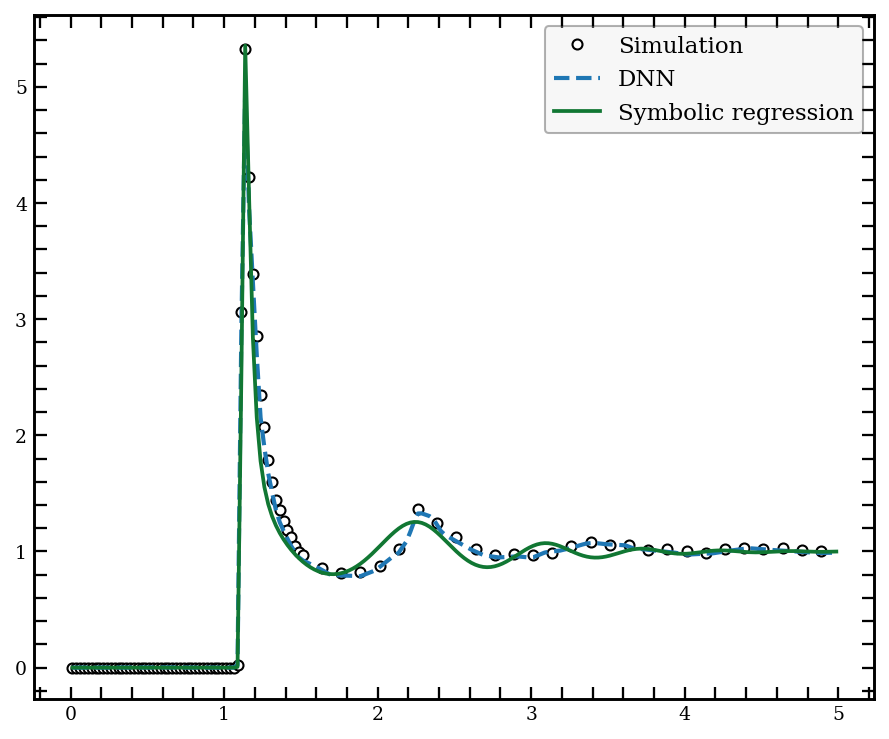

φ=0.3, Pe=25 | DNN: RMSE=0.0371, R²=0.998 | SR: RMSE=0.168, R²=0.970


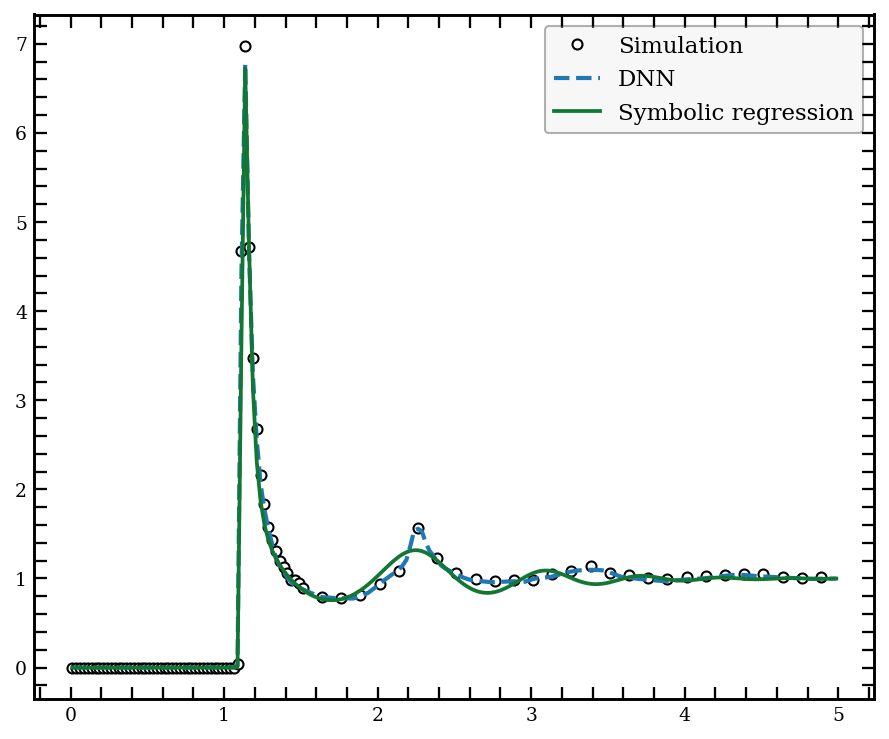

φ=0.3, Pe=35 | DNN: RMSE=0.0422, R²=0.998 | SR: RMSE=0.191, R²=0.971


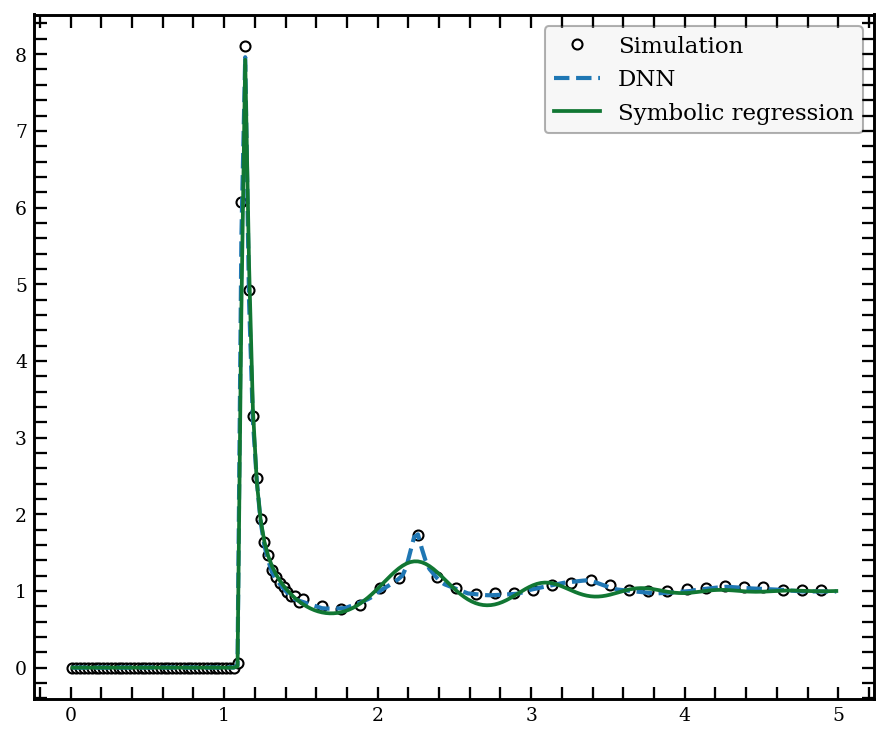

φ=0.35, Pe=15 | DNN: RMSE=0.0524, R²=0.994 | SR: RMSE=0.193, R²=0.945


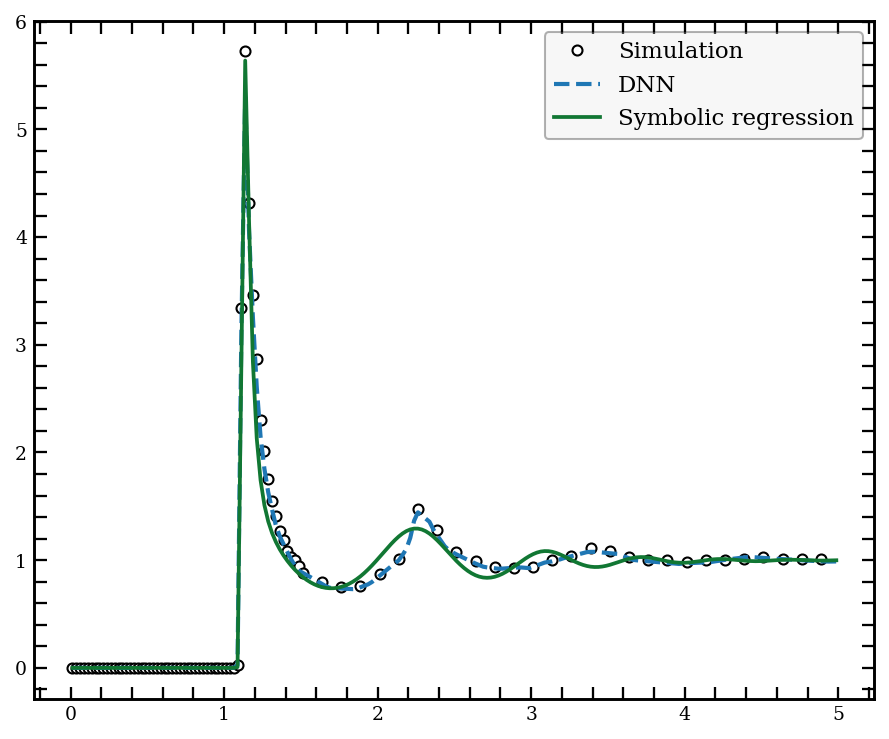

φ=0.35, Pe=25 | DNN: RMSE=0.0388, R²=0.998 | SR: RMSE=0.166, R²=0.975


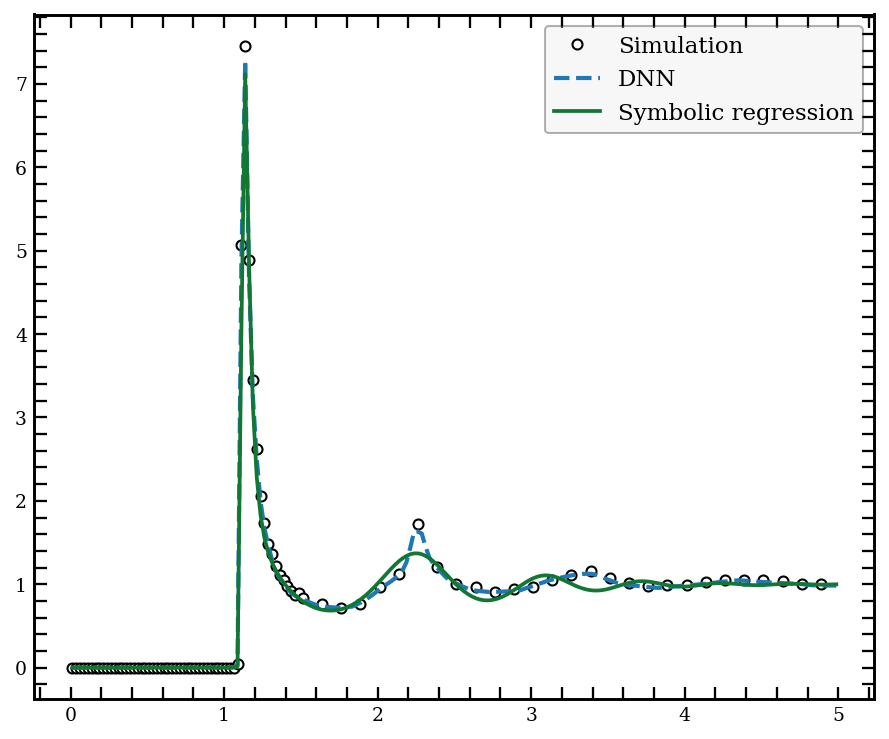

φ=0.35, Pe=35 | DNN: RMSE=0.0338, R²=0.999 | SR: RMSE=0.227, R²=0.966


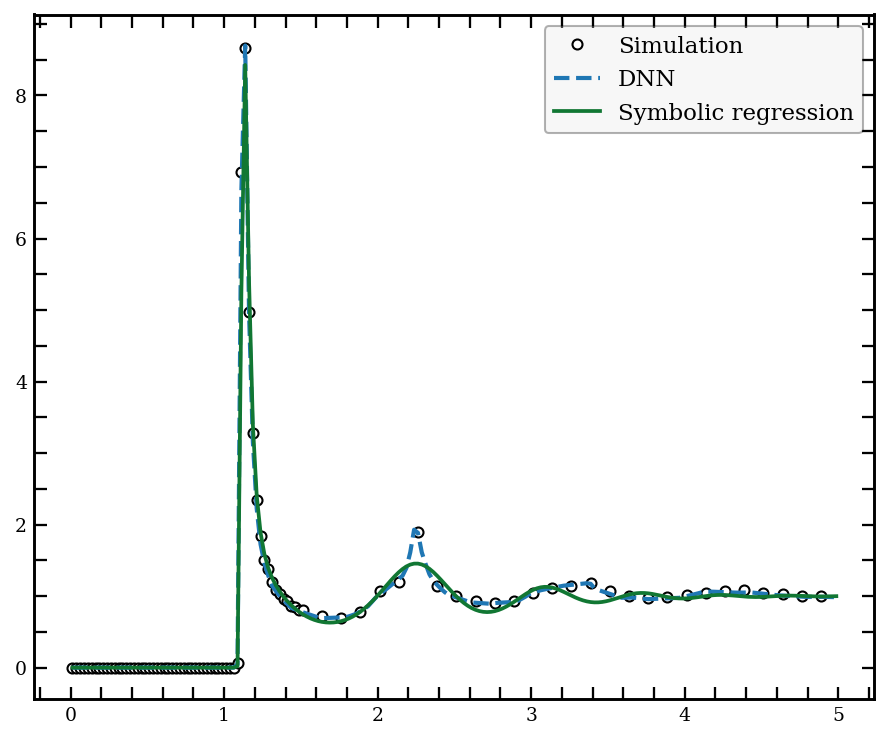

φ=0.4, Pe=15 | DNN: RMSE=0.0436, R²=0.996 | SR: RMSE=0.19, R²=0.953


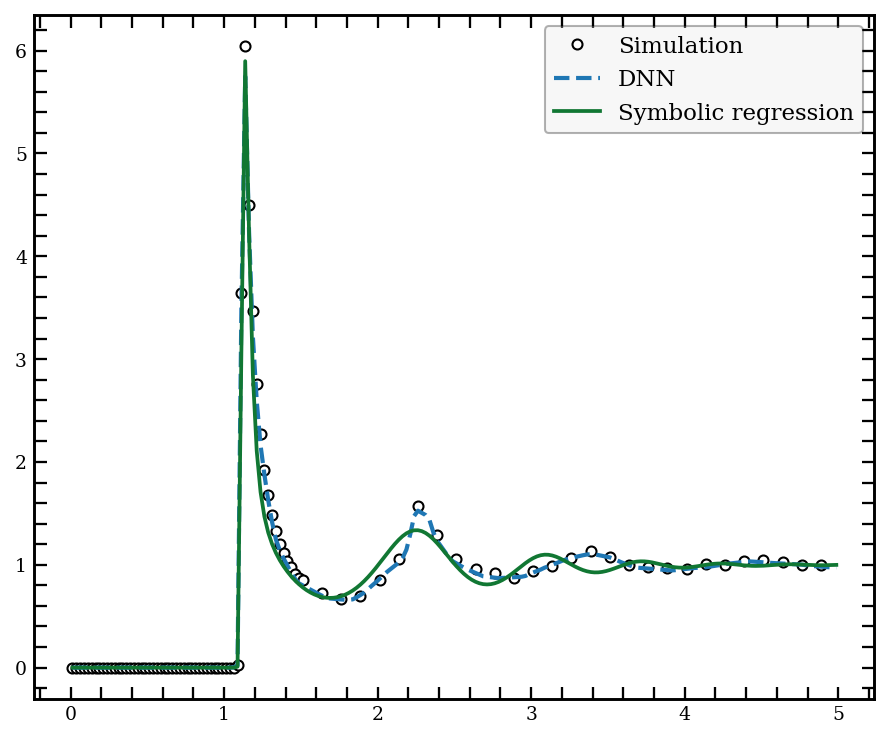

φ=0.4, Pe=25 | DNN: RMSE=0.0433, R²=0.997 | SR: RMSE=0.181, R²=0.974


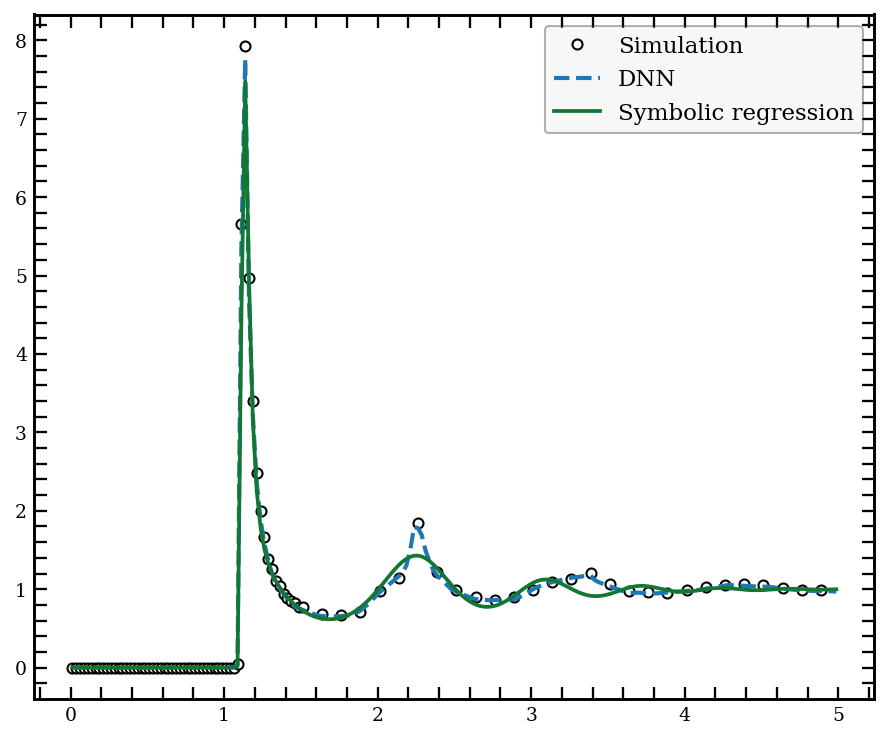

φ=0.4, Pe=35 | DNN: RMSE=0.111, R²=0.988 | SR: RMSE=0.371, R²=0.932


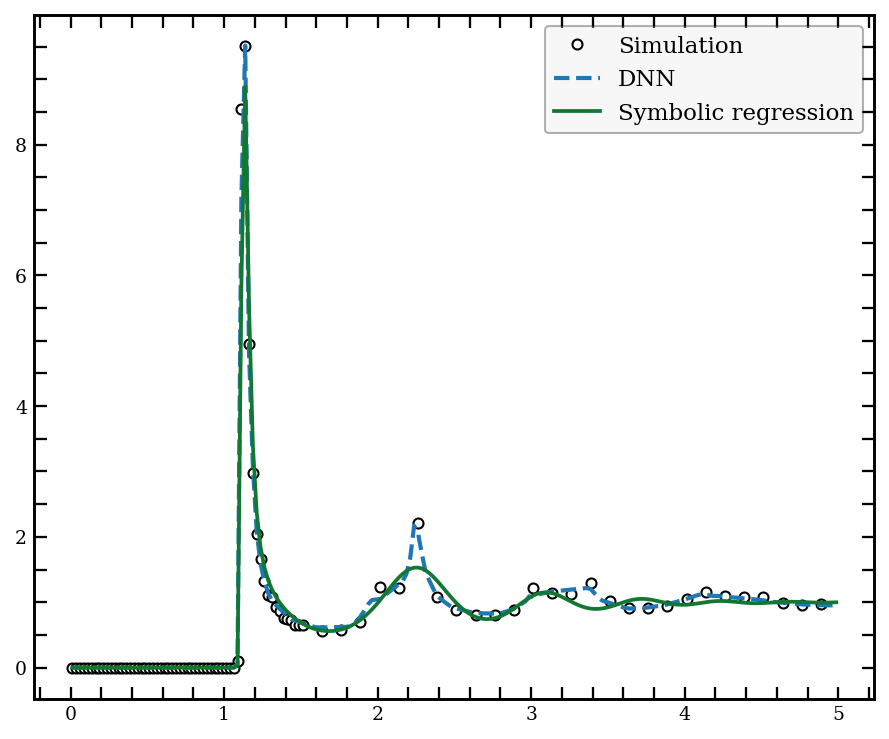

φ=0.45, Pe=15 | DNN: RMSE=0.0453, R²=0.996 | SR: RMSE=0.219, R²=0.949


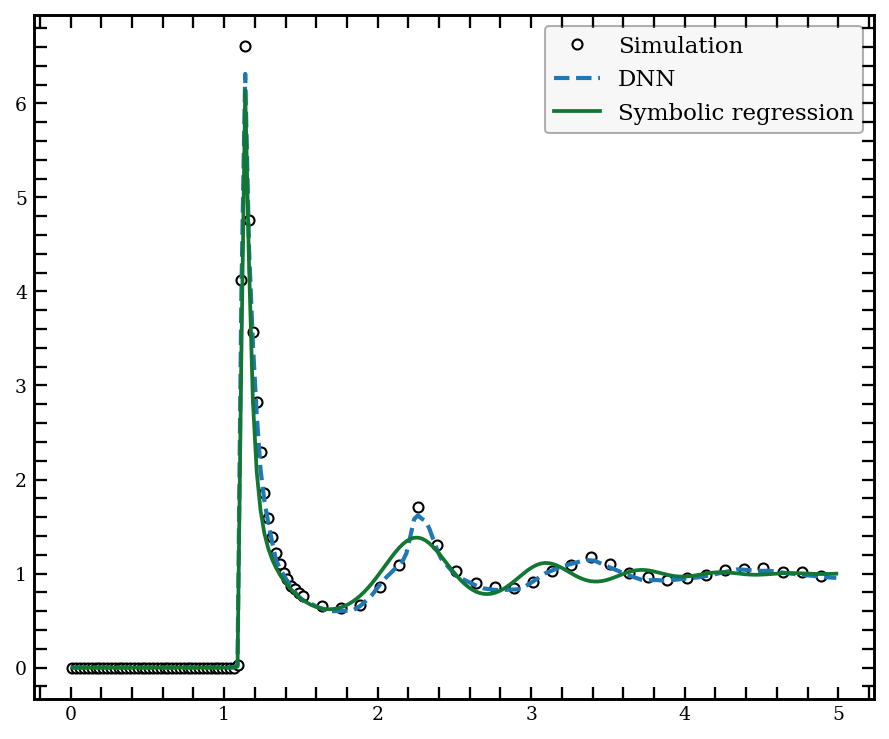

φ=0.45, Pe=25 | DNN: RMSE=0.0601, R²=0.995 | SR: RMSE=0.197, R²=0.973


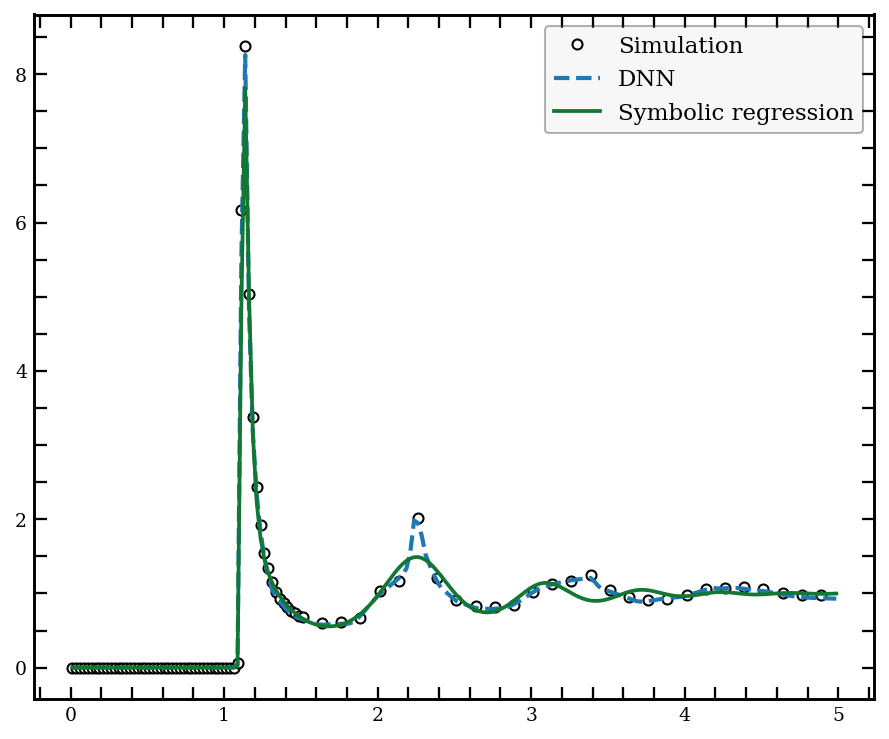

φ=0.45, Pe=35 | DNN: RMSE=0.123, R²=0.986 | SR: RMSE=0.354, R²=0.941


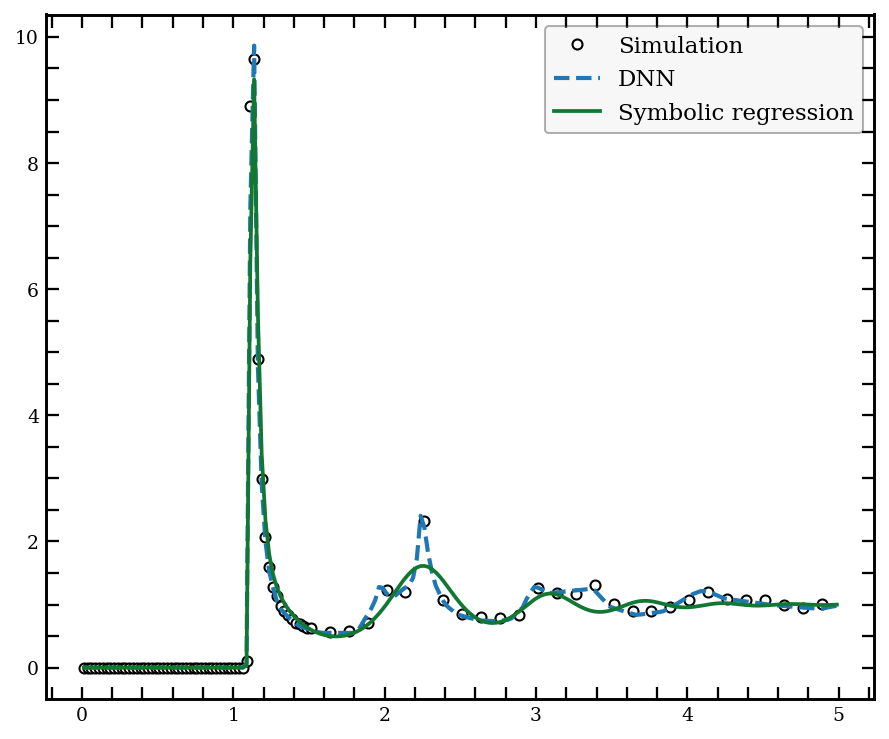

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def make_plot_integrated(phi, pe):
    # ----------------------------
    # Filter & sort
    # ----------------------------
    real_subset = final_df_avg[
        (final_df_avg["phi"] == phi) &
        (final_df_avg["Pe"] == pe)
    ].copy()

    model_subset = df_plotting[
        (df_plotting["phi"] == phi) &
        (df_plotting["Pe"] == pe)
    ].copy()

    real_subset  = real_subset.sort_values("r")
    model_subset = model_subset.sort_values("r")

    r = np.sort(real_subset["r"].unique())

    G_real  = real_subset["g_avg"].to_numpy()
    G_dnn   = model_subset["g"].to_numpy()

    # ----------------------------
    # Symbolic regression
    # ----------------------------
    try:
        G_sym = f_model(phi, pe, r)
    except Exception as e:
        print(f"Symbolic regression failed for φ={phi}, Pe={pe}: {e}")
        G_sym = np.full_like(G_dnn, np.nan)

    # ----------------------------
    # Metrics (vs simulation)
    # ----------------------------
    r_min_phys = 1.05
    r_max_analytical = 3.0

    mask_analytical = (
        (r >= r_min_phys) &
        (r <= r_max_analytical)
    )
    G_real_eval = G_real[mask_analytical]
    G_sym_eval = G_sym[mask_analytical]
    
    rmse_dnn = np.sqrt(mean_squared_error(G_real, G_dnn))
    mae_dnn  = mean_absolute_error(G_real, G_dnn)
    r2_dnn   = r2_score(G_real, G_dnn)

    rmse_sym = np.sqrt(mean_squared_error(G_real_eval, G_sym_eval))
    mae_sym  = mean_absolute_error(G_real_eval, G_sym_eval)
    r2_sym   = r2_score(G_real_eval, G_sym_eval)

    print(
        rf"φ={phi}, Pe={pe} | "
        rf"DNN: RMSE={rmse_dnn:.3g}, R²={r2_dnn:.3f} | "
        rf"SR: RMSE={rmse_sym:.3g}, R²={r2_sym:.3f}"
    )

    # ----------------------------
    # Radial subsampling (as before)
    # ----------------------------
    r_cut = 1.5
    step  = 5

    mask_dense  = r <= r_cut
    mask_sparse = r >  r_cut

    idx_dense  = np.where(mask_dense)[0]
    idx_sparse = np.where(mask_sparse)[0][::step]

    # ----------------------------
    # Figure
    # ----------------------------
    fig, ax = plt.subplots(figsize=(6, 5))

    # Simulation (markers only)
    ax.plot(
        r[idx_dense], G_real[idx_dense],
        color='black',
        marker='o',
        markersize=4.8,
        linestyle='none',
        markerfacecolor='white',
        label='Simulation'
    )
    ax.plot(
        r[idx_sparse], G_real[idx_sparse],
        color='black',
        marker='o',
        markersize=4.8,
        linestyle='none',
        markerfacecolor='white'
    )

    # DNN
    ax.plot(
        r, G_dnn,
        color='tab:blue',
        linestyle='--',
        linewidth=2.0,
        label='DNN'
    )

    # Symbolic regression
    ax.plot(
        r, G_sym,
        color='#117733',
        linestyle='-',
        linewidth=1.8,
        label='Symbolic regression'
    )

    # ----------------------------
    # Styling
    # ----------------------------
    prettify(ax)

    ax.legend(
        frameon=True,
        facecolor="#e6e6e6",
        edgecolor="black",
        framealpha=0.3,
        fancybox=True,
        fontsize=11,
        loc="upper right"
    )

    plt.tight_layout()

    # ----------------------------
    # Save
    # ----------------------------
    #plt.savefig(out_dir / f'ABP_Sim_DNN_SR_Pe{pe}_phi_{phi}.svg', bbox_inches="tight")
    plt.show()
    plt.close()
Phi_values = np.unique(final_df_avg['phi'])[:-1]
Pe_values  = np.unique(final_df_avg['Pe'])[2:-1]

for phi in Phi_values:
    for pe in Pe_values:
        make_plot_integrated(phi, pe)


# Visualization for the paper



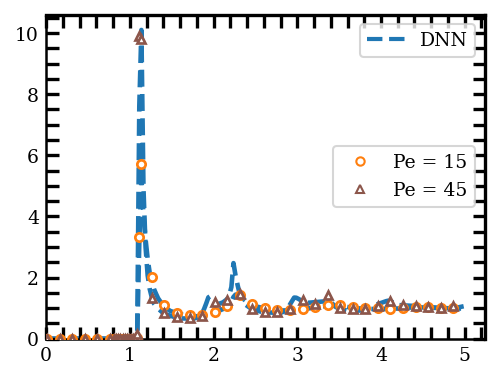

In [45]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
# ----------------------------------
# Fixed comparison cases
# ----------------------------------
cases = [
    #{"phi": 0.30, "Pe": 15, "marker": "o", "colour":"tab:orange"},
    {"phi": 0.35, "Pe": 15, "marker": "o", "colour":"tab:orange"},
    #{"phi": 0.30, "Pe": 35, "marker": "s"},
    {"phi": 0.35, "Pe": 45, "marker": "^", "colour":"tab:brown"},
]

fig, ax = plt.subplots(figsize=(3.4, 2.6))
ax.set_facecolor("white")

# -----------------------------
# Axes styling
# -----------------------------
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.6)
    spine.set_color("black")

ax.tick_params(
    axis='both', which='both',
    direction='in', top=True, bottom=True, left=True, right=True,
    length=6, width=1.6
)
ax.minorticks_on()
ax.grid(False)

# ----------------------------------
# Plot each (Pe, φ)
# ----------------------------------

for case in cases:
    phi = case["phi"]
    pe  = case["Pe"]
    marker = case["marker"]
    col = case["colour"]
    # --- Filter & sort ---
    real_subset = final_df_avg[
        np.isclose(final_df_avg["phi"], phi) &
        np.isclose(final_df_avg["Pe"], pe)
    ].sort_values("r")

    model_subset = df_plotting[
        np.isclose(df_plotting["phi"], phi) &
        np.isclose(df_plotting["Pe"], pe)
    ].sort_values("r")
    if real_subset.empty:
        raise ValueError(f"No simulation data for phi={phi}, Pe={pe}")
    
    if model_subset.empty:
        raise ValueError(f"No DNN data for phi={phi}, Pe={pe}")

    r = real_subset["r"].to_numpy()
    G_real = real_subset["g_avg"].to_numpy()
    G_dnn  = model_subset["g"].to_numpy()

    # --- Subsampling (same logic as before) ---
    
    # --- Subsampling (same logic as before) ---
    r_dense_min = 0.8
    r_dense_max = 1.15
    sparse_step = 6
    # Dense region mask
    mask_dense = (r >= r_dense_min) & (r <= r_dense_max)
    idx_dense = np.where(mask_dense)[0]
    # Sparse region mask (outside dense window)
    mask_sparse = ~mask_dense
    idx_sparse_all = np.where(mask_sparse)[0]
    idx_sparse = idx_sparse_all[::sparse_step]
    
    # Make sure peak is included
    idx_plot = np.unique(np.concatenate([idx_sparse, idx_dense]))
    
    #print(f"phi={phi}, Pe={pe}: forced r = {r[idx_peak]:.6f}, g = {G_real[idx_peak]}")
    #print(f"phi={phi}, Pe={pe}: max g = {np.nanmax(G_real):.4f} at r = {r[np.nanargmax(G_real)]:.6f}")

    # --- Simulation ---
    ax.plot(
        r[idx_plot], G_real[idx_plot],
        color=col,
        marker=marker,
        linestyle='none',
        markersize=4.0,
        markerfacecolor='white',
        markeredgewidth=1.3,
        zorder=5
    )

    # --- DNN ---
    ax.plot(
        r, G_dnn,
        color='tab:blue',
        linestyle='--',
        linewidth=2.2,
        label = 'DNN',
        zorder=1
    )

    # Legends
    
    # φ legend (marker only)
    phi_legend = [
        Line2D([0], [0],
               color= case['colour'], #'black',
               marker=case["marker"],
               linestyle='none',
               markersize=4.0,
               markerfacecolor='white',
               label=rf"Pe = {case['Pe']}") #$\varphi = {case['phi']}$, 
        for case in cases
    ]

leg_phi = ax.legend(
    handles=phi_legend,
    loc='center right',
    frameon=True,
)
ax.add_artist(leg_phi)

# Model legend (color / style only)

model_legend = [
    # Simulation: multiple markers → conveys "markers only"
    Line2D([0], [0], color='tab:blue', linewidth=2, linestyle='--', label='DNN'), #, linewidth=2
]
#legend = model_legend+phi_legend
ax.legend(
    handles=model_legend,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc='upper right',
    frameon=True,
)

ax.set_xlim(0, None)
ax.set_ylim(0, None)

ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.tick_params(direction='in', length=6, width=1.6)

plt.tight_layout()
#plt.savefig(out_dir / "ABP_Sim_DNN_selected_Pe_0.45.svg", bbox_inches="tight")
plt.show()
plt.close()


# Visualization of the expression we got

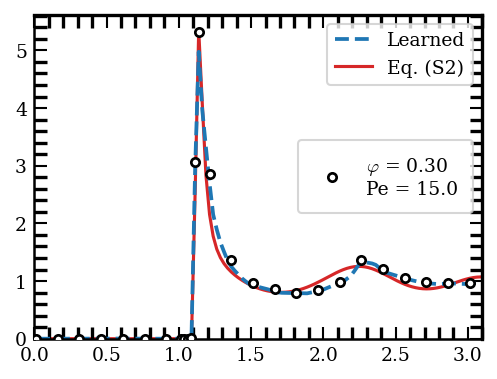

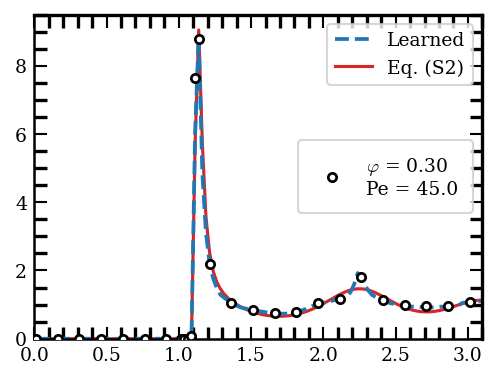

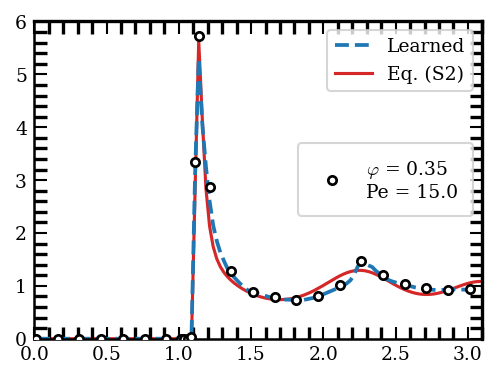

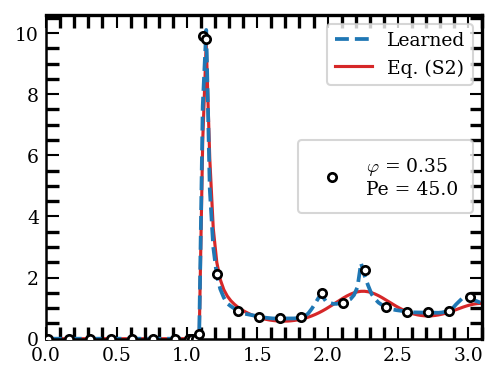

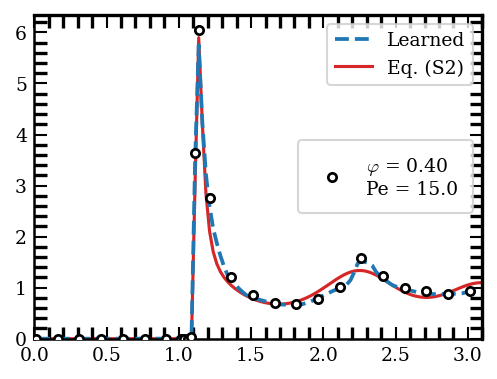

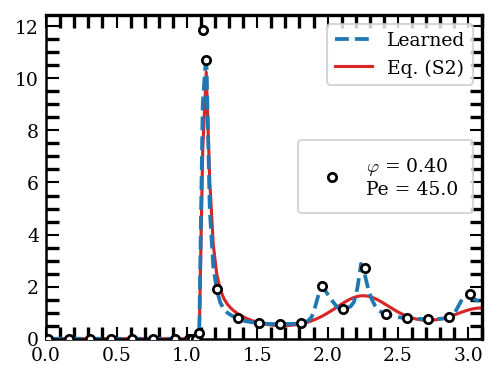

In [163]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
import numpy as np
#from matplotlib.cm import get_cmap
phi_arr = [0.3, 0.35, 0.4]
Pe_arr = [15, 45]
comb = np.array(np.meshgrid(phi_arr,Pe_arr)).T.reshape(-1,2)
for i in comb:
    fig, ax = plt.subplots(figsize=(3.4, 2.6))
    ax.set_facecolor("white")
    phi, pe = i[0], i[1]
    # ----------------------------------
    # Axes styling
    # ----------------------------------
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.6)
        spine.set_color("black")
    
    ax.tick_params(
        axis='both', which='both',
        direction='in', top=True, bottom=True, left=True, right=True,
        length=6, width=1.6
    )
    ax.minorticks_on()
    ax.grid(False)
    marker = 'o'
    col = 'black'
    # --- Filter & sort ---
    real_subset = final_df_avg[
        np.isclose(final_df_avg["phi"], phi) &
        np.isclose(final_df_avg["Pe"], pe)
    ].sort_values("r")
    
    model_subset = df_plotting[
        np.isclose(df_plotting["phi"], phi) &
        np.isclose(df_plotting["Pe"], pe)
    ].sort_values("r")
    
    if real_subset.empty:
        raise ValueError(f"No simulation data for phi={phi}, Pe={pe}")
    
    if model_subset.empty:
        raise ValueError(f"No DNN data for phi={phi}, Pe={pe}")

    r = real_subset["r"].to_numpy()
    G_real = real_subset["g_avg"].to_numpy()
    G_dnn  = model_subset["g"].to_numpy()
    
    # --- Subsampling (same logic as before) ---
    r_dense_min = 1.0
    r_dense_max = 1.15
    sparse_step = 6
    # Dense region mask
    mask_dense = (r >= r_dense_min) & (r <= r_dense_max)
    idx_dense = np.where(mask_dense)[0]
    # Sparse region mask (outside dense window)
    mask_sparse = ~mask_dense
    idx_sparse_all = np.where(mask_sparse)[0]
    idx_sparse = idx_sparse_all[::sparse_step]
    
    # Make sure peak is included
    idx_plot = np.unique(np.concatenate([idx_sparse, idx_dense])) # [np.nanargmax(G_real)]]))
    
    #print(f"phi={phi}, Pe={pe}: forced r = {r[idx_peak]:.6f}, g = {G_real[idx_peak]}")
    #print(f"phi={phi}, Pe={pe}: max g = {np.nanmax(G_real):.4f} at r = {r[np.nanargmax(G_real)]:.6f}")

    # --- Simulation ---
    ax.plot(
        r[idx_plot], G_real[idx_plot],
        color=col,
        marker=marker,
        linestyle='none',
        markersize=4,
        markerfacecolor='white',
        markeredgewidth=1.3,
        #label = rf"Pe = {pe}, $\varphi$ = {phi:.2f}",
        zorder=5
    )
    
    # --- DNN ---
    ax.plot(
        r, G_dnn,
        color='tab:blue',
        linestyle='--',
        linewidth=1.8,
        label = 'Learned', #DNN
        zorder=2
    )
    
    # Symbolic regression plot
    ax.plot(
        r,
        f_model(phi, pe, r),
        color='tab:red',
        linewidth=1.5,
        label = 'Eq. (S2)',
        zorder=1
    )


    ax.set_xlim(0, 3.1)
    ax.set_ylim(0, None)
    
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.tick_params(direction='in', length=6, width=1.0)
    phi_legend = [
            Line2D(
                [0], [0],
                color= 'black',
                marker= marker,
                linestyle='none',
                markersize=4,
                markerfacecolor='white',
                markeredgewidth=1.3,
                #label=rf"($\phi$, Pe) = ({c['phi']:.2f}, {c['Pe']})",
                label=f"$\\varphi$ = {phi:.2f}\nPe = {pe}",  #rf"Pe = {c['Pe']}"
            )
            
        ]
    
    leg_phi = ax.legend(
        handles=phi_legend,
        loc='center right',
        **legend_kw
    )
    ax.add_artist(leg_phi)
    ax.legend()
    fig.tight_layout()
    out_dir_fig = Path("my_saved_models_pysr")
    out_dir_fig.mkdir(parents=True, exist_ok=True)
    #fig.savefig(out_dir / f"ABP_symbolic_Pe_{pe}_phi_{phi}_final.svg", bbox_inches="tight", transparent=True)
    plt.show()
    plt.close(fig)


# zoomed visualization with the learned expression

In [176]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Zoom limits
# -------------------------------
ZOOM_X = (0.9, 1.27)
#ZOOM_Y = (4.8, 11.0)
ZOOM_Y = (5.0, 11.5)
fig, ax = plt.subplots(figsize=(1.6, 1.4))
ax.set_facecolor("white")

# -------------------------------
# Axes styling
# -------------------------------
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.0)
    spine.set_color("black")

ax.tick_params(
    axis='both', which='both',
    direction='in', top=True, bottom=True, left=True, right=True,
    length=4, width=1.0, labelsize = 12
)
ax.minorticks_on()
ax.grid(False)

# -------------------------------
# Plot both cases
# -------------------------------
for case in cases:
    phi = case["phi"]
    pe  = case["Pe"]
    marker = case["marker"]
    col = 'black'

    real_subset = final_df_avg[
        np.isclose(final_df_avg["phi"], phi) &
        np.isclose(final_df_avg["Pe"], pe)
    ].sort_values("r")

    model_subset = df_plotting[
        np.isclose(df_plotting["phi"], phi) &
        np.isclose(df_plotting["Pe"], pe)
    ].sort_values("r")

    r = real_subset["r"].to_numpy()
    G_real = real_subset["g_avg"].to_numpy()
    G_dnn  = model_subset["g"].to_numpy()

    # --- SAME dense sampling as main plot ---
    r_dense_min = 1.0
    r_dense_max = 1.25
    sparse_step = 6

    mask_dense = (r >= r_dense_min) & (r <= r_dense_max)
    idx_dense = np.where(mask_dense)[0]

    idx_sparse_all = np.where(~mask_dense)[0]
    idx_sparse = idx_sparse_all[::sparse_step]

    idx_plot = np.unique(np.concatenate([idx_sparse, idx_dense]))

    # Simulation (markers)
    ax.plot(
        r[idx_plot], G_real[idx_plot],
        color=col,
        marker=marker,
        linestyle='none',
        markersize=5.0,
        markerfacecolor='white',
        markeredgewidth=1.3,
        zorder=5
    )

    # DNN (line)
    ax.plot(
        r, G_dnn,
        color='tab:blue',
        linestyle='--',
        linewidth=1.8,
        zorder=2
    )
    # Symbolic regression plot
    ax.plot(
        r,
        f_model(phi, pe, r),
        color='tab:red',
        linewidth=2.2,
        zorder=1
    )
# -------------------------------
# Zoom limits
# -------------------------------
ax.set_xlim(*ZOOM_X)
ax.set_ylim(*ZOOM_Y)

#ax.tick_params(labelbottom=False, labelleft=False)

plt.tight_layout()
#plt.show()
plt.savefig(out_dir /f"abp_symbolic_zoom_0.45_Pe.svg", bbox_inches="tight")
plt.close()
